# What is the hydrological complexity of the UK?

TODO: relative to the skill of the persistence/climatology scores

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Load in driving data

In [16]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Check runs

In [6]:
run_dir = (data_dir / "runs/complexity")

list(run_dir.iterdir())

[PosixPath('/cats/datastore/data/runs/complexity/hs_008_0303_181518'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_128_0303_181520'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_032_0303_181522'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_004_0303_181524'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_016_0403_082704'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_256_0403_082706'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_064_0403_155703'),
 PosixPath('/cats/datastore/data/runs/complexity/all_results.nc'),
 PosixPath('/cats/datastore/data/runs/complexity/all_errors.pkl')]

In [7]:
all_preds = xr.open_dataset(run_dir / "all_results.nc")

In [8]:
from scripts.drafts.io_results import members_from_coords_to_variables

all_preds = members_from_coords_to_variables(all_preds)

In [9]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

filepath = run_dir / "all_errors.pkl"

if filepath.exists():
    all_errors = pickle.load(filepath.open("rb"))
else:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True, yilmaz_errors=True)
    with filepath.open("wb") as fp:
        pickle.dump(all_errors, fp)

In [10]:
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
metrics_xr = xr.Dataset(all_metrics).rename({"dim_1": "model"})

experiment_names = [m for m in metrics_xr.model.values]
hidden_sizes = [int(m.split("_")[1]) for m in metrics_xr.model.values]
metrics_xr["model"] = hidden_sizes
metrics_xr = metrics_xr.rename({"model": "hidden_size"})

metrics_xr

<xarray.Dataset>
Dimensions:                 (hidden_size: 7, station_id: 667)
Coordinates:
  * station_id              (station_id) int64 10002 10003 1001 ... 96004 97002
  * hidden_size             (hidden_size) int64 4 8 16 32 64 128 256
Data variables:
    sqrt_variability_ratio  (station_id, hidden_size) float64 0.9382 ... 0.9542
    inv_variability_ratio   (station_id, hidden_size) float64 2.323 ... 0.6546
    variability_ratio       (station_id, hidden_size) float64 0.7484 ... 0.8797
    sqrt_correlation        (station_id, hidden_size) float64 0.9081 ... 0.954
    inv_correlation         (station_id, hidden_size) float64 0.8153 ... 0.8678
    sqrt_bias_ratio         (station_id, hidden_size) float64 0.8535 ... 0.9855
    inv_bias_ratio          (station_id, hidden_size) float64 1.638 ... 0.9302
    abs_pct_bias            (station_id, hidden_size) float64 25.09 ... 4.227
    correlation             (station_id, hidden_size) float64 0.8934 ... 0.9293
    bias_error              (station_id, hidden_size) float64 -0.2509 ... -0....
    bias_ratio              (station_id, hidden_size) float64 0.7491 ... 0.9577
    std_error               (station_id, hidden_size) float64 -0.2516 ... -0....
    mam30_ape               (station_id, hidden_size) float32 48.18 ... 23.73
    sqrt_kge                (station_id, hidden_size) float64 0.8163 ... 0.9335
    log_nse                 (station_id, hidden_size) float64 0.4419 ... 0.9134
    inv_kge                 (station_id, hidden_size) float64 -0.4804 ... 0.6236
    member                  (station_id, hidden_size) object 'hs_004_0303_181...
    pbias                   (station_id, hidden_size) float64 25.09 ... 4.227
    bias                    (station_id, hidden_size) float64 -25.09 ... -4.227
    mape                    (station_id, hidden_size) float64 32.27 ... 23.71
    rmse                    (station_id, hidden_size) float64 0.8041 ... 0.9412
    nse                     (station_id, hidden_size) float64 0.7134 ... 0.8599
    kge                     (station_id, hidden_size) float64 0.6291 ... 0.8542
    mse                     (station_id, hidden_size) float64 0.6466 ... 0.8859
    fms                     (station_id, hidden_size) float64 18.58 ... 8.37
    flv                     (station_id, hidden_size) float64 -96.06 ... 49.31
    fhv                     (station_id, hidden_size) float64 -28.66 ... -11.5

# Overall complexity required?

In [11]:
hidden_sizes

[4, 8, 16, 32, 64, 128, 256]

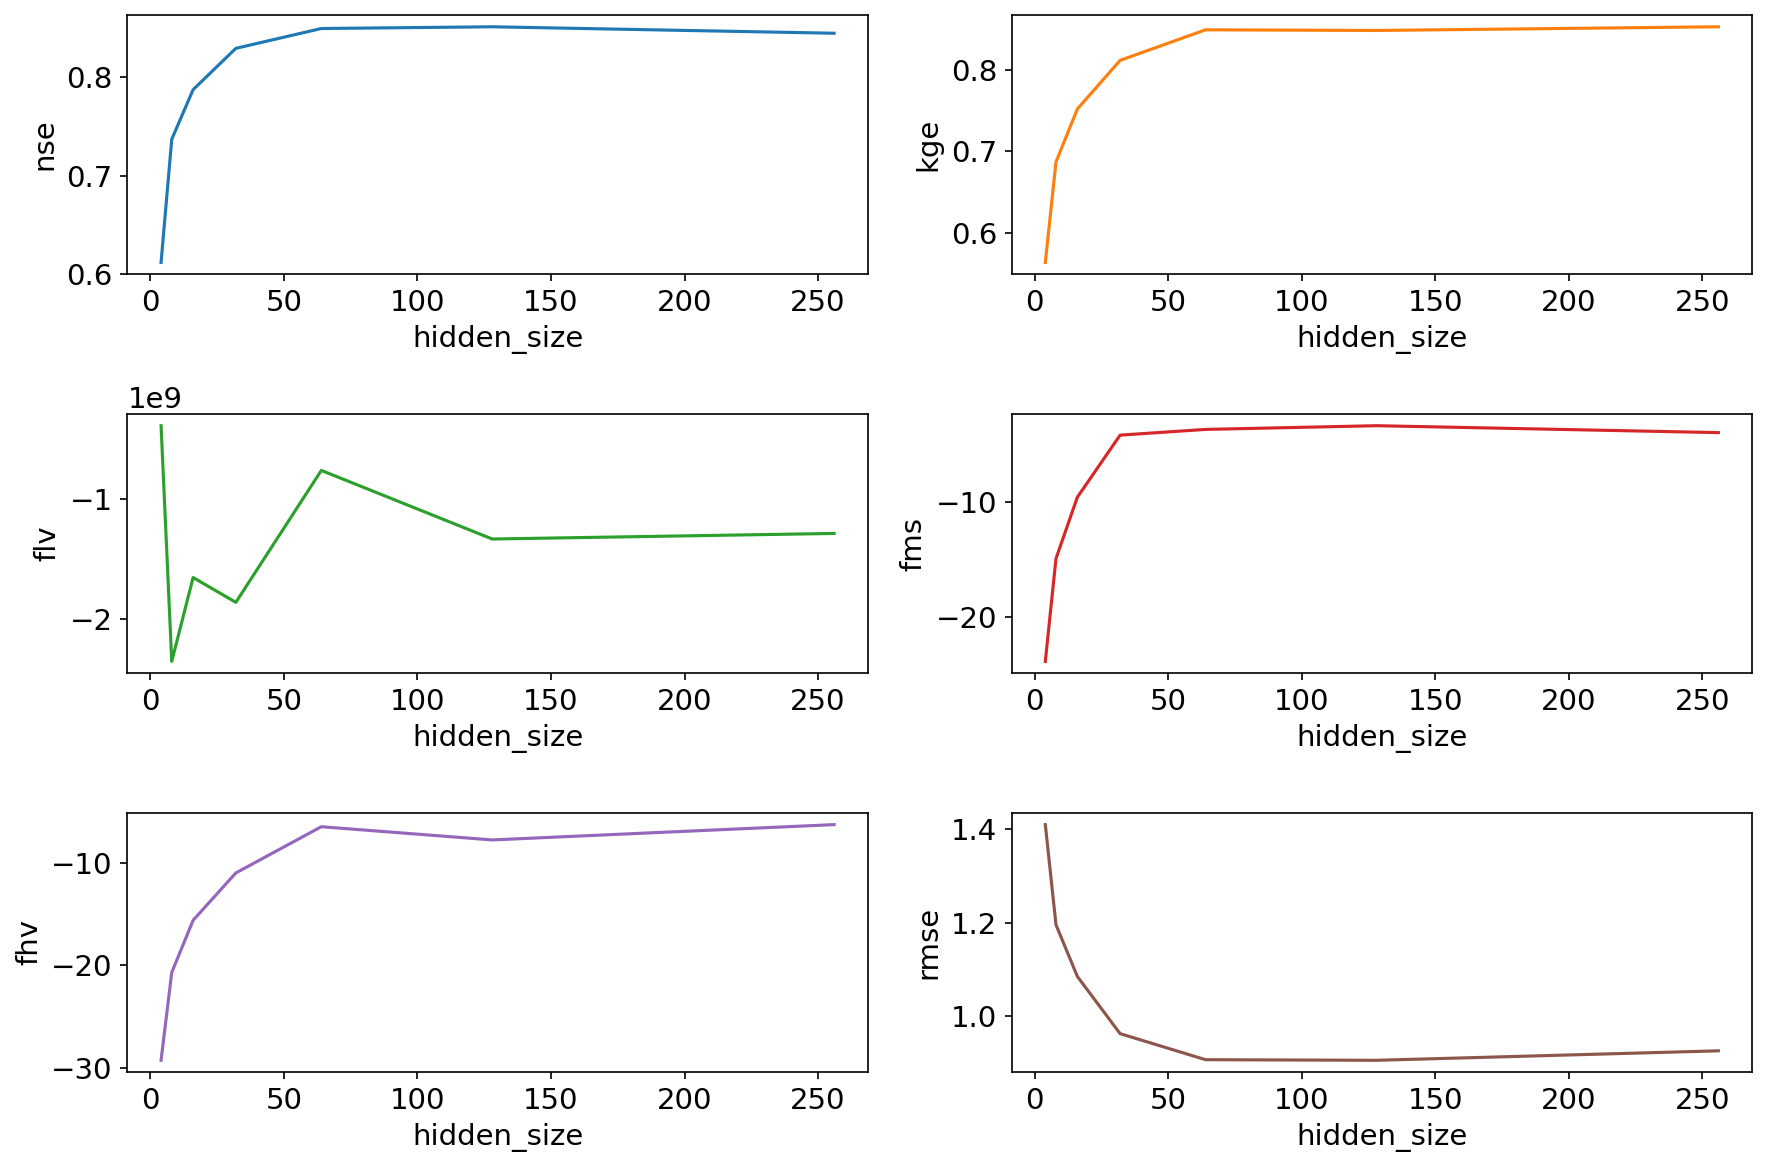

In [12]:
f, axs = plt.subplots(3, 2, figsize=(12, 8))
metrics = ["nse", "kge", "flv", "fms", "fhv", "rmse"]
for ix, metric in enumerate(metrics):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metrics_xr[metric].mean(dim="station_id").plot(ax=ax, color=f"C{ix}")
    
plt.tight_layout()

# CDFs 

In [13]:
from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

colors = sns.color_palette("viridis", 7)
kwargs_dict = {
    'hs_004_0303_181524': {"color":colors[0], "alpha": 0.7},
    'hs_008_0303_181518': {"color":colors[1], "alpha": 0.7},
    'hs_016_0403_082704': {"color":colors[2], "alpha": 0.7},
    'hs_032_0303_181522': {"color":colors[3], "alpha": 0.7},
    'hs_064_0403_155703': {"color":colors[4], "alpha": 0.7},
    'hs_128_0303_181520': {"color":colors[5], "alpha": 0.7},
    'hs_256_0403_082706': {"color":colors[6], "alpha": 0.7},

}

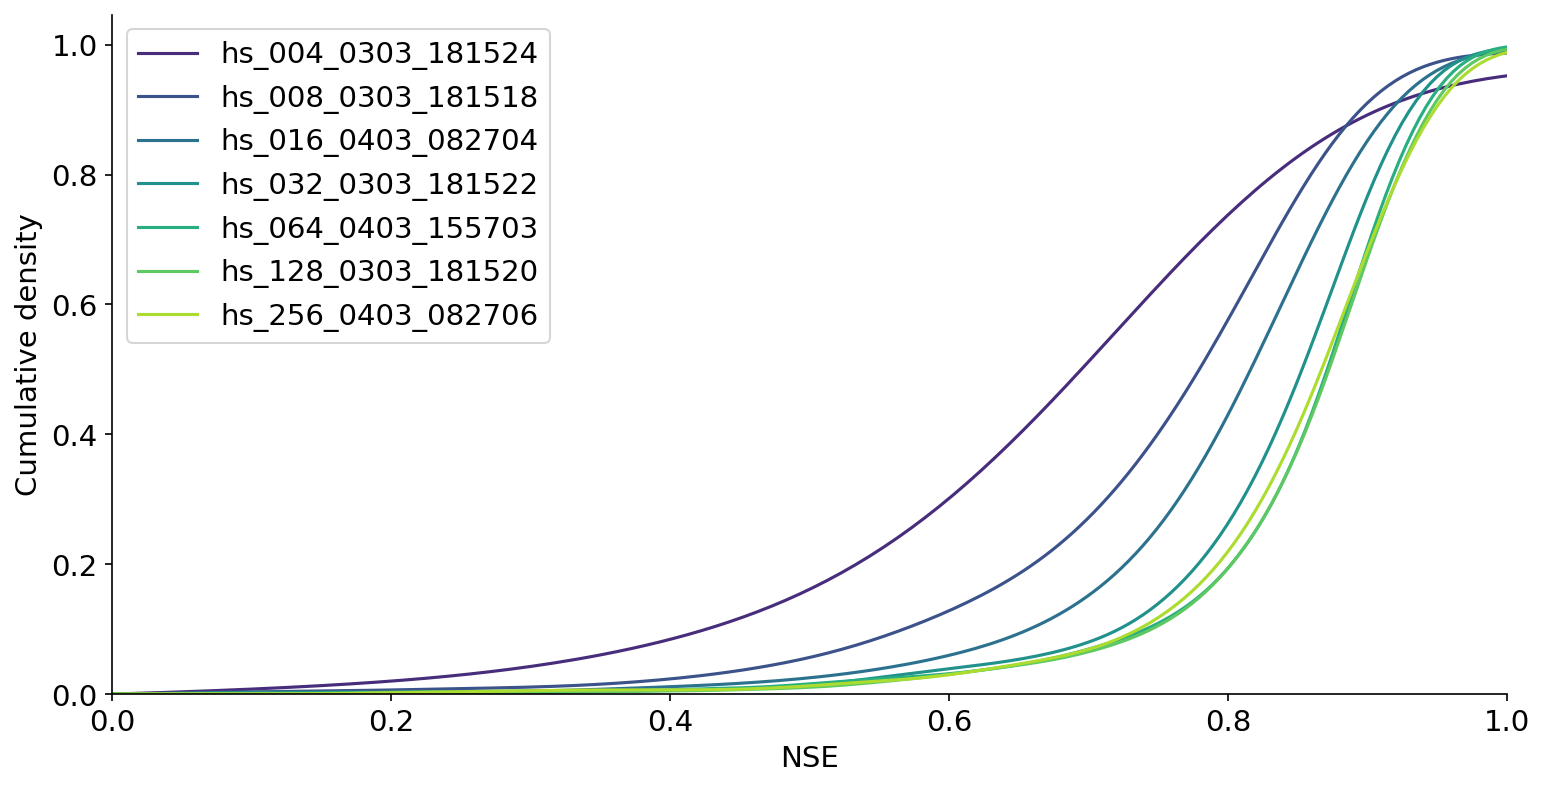

In [14]:
scale = 1.
f, ax = plt.subplots(figsize=(12*scale, 6*scale))
metrics = all_metrics["nse"].drop([c for c in  all_metrics["nse"].columns if "climatology" in c or "persistence" in c], axis=1)
plot_cdf(metrics, metric="NSE", title="", ax=ax, clip=(0, 1), median=True, summary_line=False, kwargs_dict=kwargs_dict);

# Geospatial Patterns

In [20]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [21]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [22]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Any, Optional, Dict


markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "log_nse": {"vmin": 0.6, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # log nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'cividis_r', "markersize": markersize},    # kge   
    "inv_kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "mape": {"vmin": 0, "vmax": None, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},    # bias  
    "abs_pct_bias": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # abs_pct_bias
    "mam30_ape": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # mam30_ape  
    "correlation":{"vmin": 0.85, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},
    "bias_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},  
    "variability_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},
    "bias_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},  
    "std_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv":{"vmin": -100, "vmax": 100, 'cmap': 'RdBu', "markersize": markersize},
    "fms":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
    "fhv":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
}

from typing import List, Any 


def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _add_colorbar(ax: Any, kwargs: Dict[str, float], title: str = ""):
    assert all(np.isin(["cmap", "vmin", "vmax"], [k for k in kwargs.keys()]))
    # get the legend / colorbar
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=kwargs["cmap"], norm=plt.Normalize(vmin=kwargs["vmin"], vmax=kwargs["vmax"]))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    # cbar.set_label('title', rotation=270)


def _plot_geospatial(metric_data: gpd.GeoDataFrame, column: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(column, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

def plot_geospatial_data_per_model(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    assert all(np.isin(metrics, model_data.columns))
    
    n_metrics = len(metrics)
    if n_metrics == 3:
        fig, axs = plt.subplots(1, 3, figsize=(5*n_metrics, 8))
        shape = (1, 3)
    else:
        nrows = (n_metrics // 2) + (n_metrics % 2)
        fig, axs = plt.subplots(nrows, 2, figsize=(5*2, 8*nrows))
        shape = (nrows, 2)
        
    for ix, metric in enumerate(metrics):
        ax = axs[np.unravel_index(ix, shape)]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        ax = _plot_geospatial(model_data, column=metric, ax=ax, cax=cax, kwargs=opts[metric])
        ax.set_title(metric.upper())
        
    fig.tight_layout()
#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);


def plot_geospatial_data_per_metric(metric_data, metric: str, models: List[str] = ["LSTM", "EALSTM", "SACRAMENTO"], legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    assert all(np.isin(models, metric_data.columns))
    n_models = len(models)
    
    scale = 0.6
    fig, axs = plt.subplots(1,  n_models, figsize=(5*n_models*scale, 8*scale))
    shape = (n_models,)

    for ix, model in enumerate(models):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        ax = _plot_geospatial(metric_data, column=model, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(model.upper())
        if not legend:
            pass
    fig.tight_layout()

    
def plot_metric_data_per_season(metric_data, metric="nse", legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    assert "season" in metric_data.columns
    assert all(np.isin(seasons, metric_data["season"].unique()))
    n_seasons = len(seasons)
    
    # build the subplot
    scale = 0.6
    fig, axs = plt.subplots(1,  n_seasons, figsize=(5*n_seasons*scale, 8*scale))
    shape = (n_seasons,)

    for ix, season in enumerate(seasons):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        # subset the seasonal points
        plot_data = metric_data.loc[metric_data["season"] == season]
        ax = _plot_geospatial(plot_data, column=metric, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(season.upper())
    
    fig.tight_layout()


    return

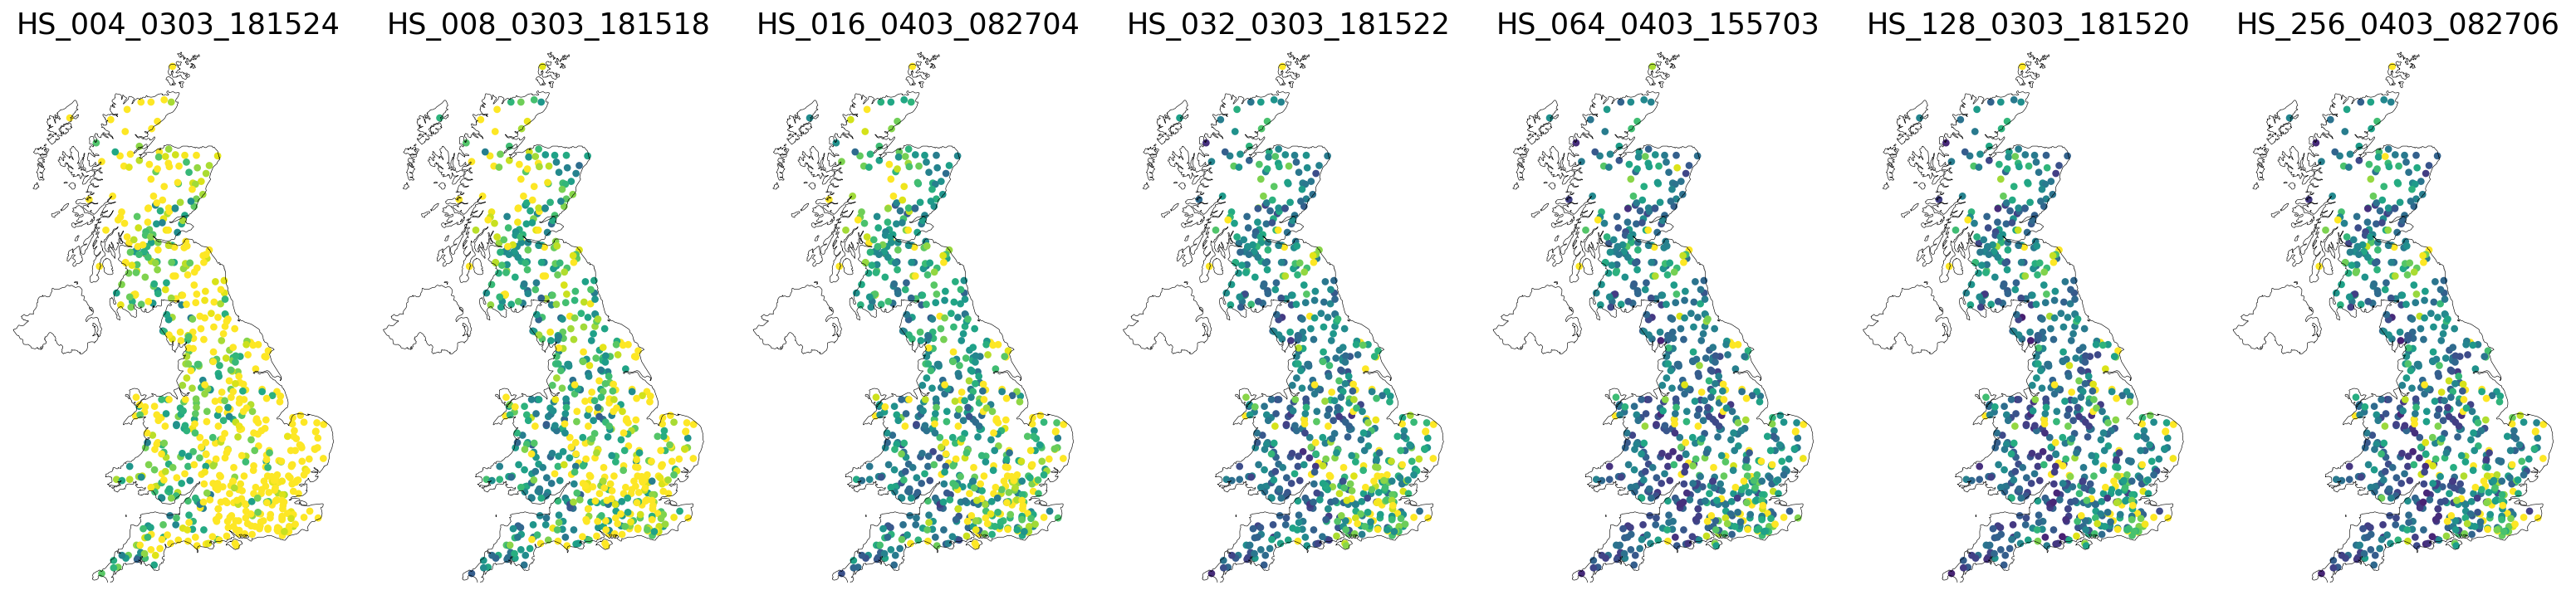

In [24]:
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["nse"]), metric="nse", models=experiment_names)

# Regional Performances

In [25]:
lakes = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_Lakes/UK_Lakes.shp").to_crs(epsg=4326)
hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]
aquifers = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "Aquifers/Uk_HydroGeology_Simplified.shp").to_crs(epsg=4326)

In [26]:
region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [28]:
regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
hydro_regions

region_gdf = create_geospatial_data(regions_list.to_frame())

In [34]:
from typing import List, Dict, Tuple

def get_region_and_UK_wide_metric(df: pd.DataFrame, agg: str = "median", models: List[str] = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',]) -> pd.DataFrame:
#     assert all(np.isin(["region", "LSTM"], df.columns))
    if agg == "median":
        # Median in each region
        med_region = df.groupby("region").median()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.median()[models].values, med_region.values])

    elif agg == "mean":
        # Mean in each region
        med_region = df.groupby("region").mean()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.mean()[models].values, med_region.values])
    else:
        assert False
        
    region = ["UK"] + [region_abbrs[l] for l in med_region.index.values]
    columns = med_region.columns
    med_region = pd.DataFrame(med_values, columns=columns, index=region)
    return med_region


def plot_matrix_of_each_region_and_model(
    df: pd.DataFrame,
    agg: str = "median",
    models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',],
    kwargs: Dict = {"cmap": "blues"}
):
    assert all(np.isin(["region", "region_abbr"], df.columns)), f"Expect [region region_abbr] to be in {df.columns}"
    assert agg in ["mean", "median"], "Expect agg to be one of median, mean"
    med_region = get_region_and_UK_wide_metric(df, agg=agg, models=models)

    # https://stackoverflow.com/a/40890587
    fig, ax = plt.subplots(figsize=(12, 8))

    intersection_matrix = med_region.values

    ax.imshow(intersection_matrix.T, **kwargs)

    for region_ix in range(intersection_matrix.shape[0]):
        for model_ix in range(intersection_matrix.shape[1]):
            c = intersection_matrix[region_ix, model_ix]
            ax.text(region_ix, model_ix, f"{c:.2f}", va='center', ha='center')

    ax.set_ylabel("Model")
    ax.set_xlabel("Region")
    ax.set_xticklabels([''] + list(med_region.index))
    ax.set_yticklabels([''] + list(med_region.columns))
    
    return ax

Text(0.5, 1.0, 'Median UK and Regional NSE')

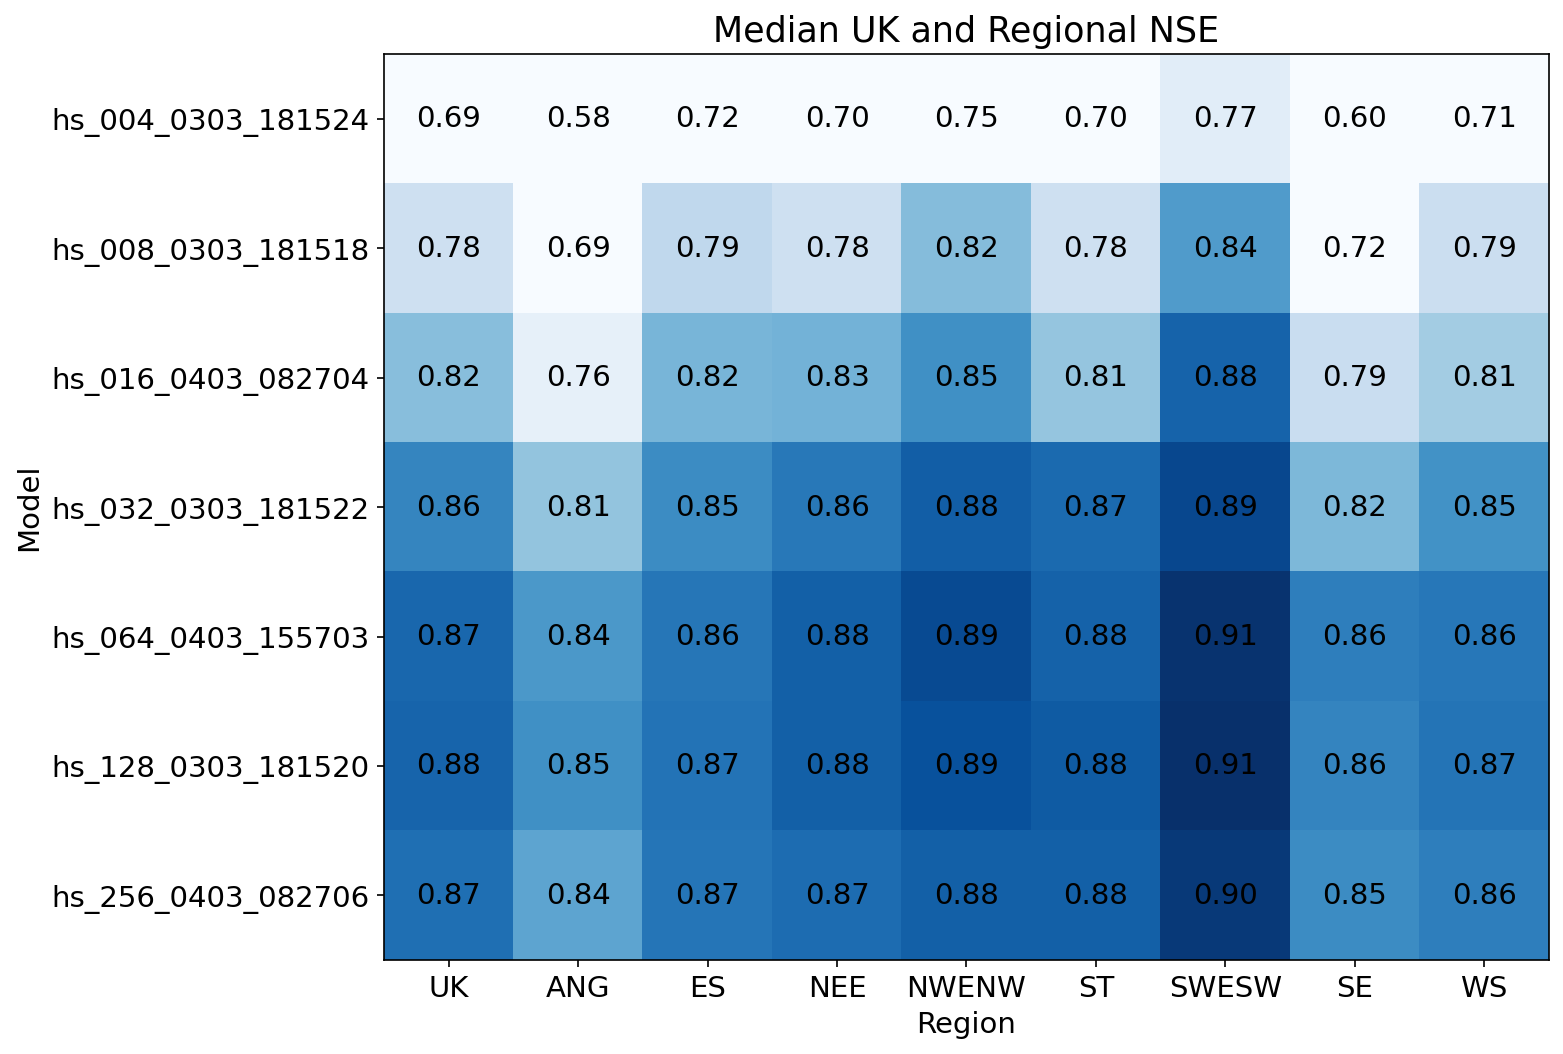

In [35]:
skill_score = False
metric = "nse"

vmin = 0.75
vmax = None
cmap = "Blues"
agg = "median"

# select table of metrics (skill-score or raw)
if skill_score:
    df = skill_scores["climatology_doy"][metric].join(regions_list)
else:
    df = all_metrics[metric].join(regions_list)

df["region_abbr"] = df["region"].map(region_abbrs)

plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": vmin, "vmax": vmax, "cmap": cmap}, models=experiment_names)
ax = plt.gca()
ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")